# Dataset info

Dataset link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption



---
**Data Set Information:**

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).<br>
Notes:
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


**Attribute Information:**

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


# Imports

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.cluster.hierarchy as hac
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from xgboost import plot_importance
from joblib import dump, load

%matplotlib inline

# Download and process the data into a pandas Dataframe.

In [ ]:
# Get dataset from UCI archive
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip

--2022-07-31 06:40:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip’

household_power_con 100%[===================>]  19.68M  21.3MB/s    in 0.9s    

2022-07-31 06:40:30 (21.3 MB/s) - ‘household_power_consumption.zip’ saved [20640916/20640916]

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
# Load into dataframe
data = pd.read_csv("household_power_consumption.txt", header=0, sep = ';', infer_datetime_format=True, parse_dates = {'Datetime': ['Date', 'Time']})
data = data.set_index('Datetime')

display(data.head())
display(data.info())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Global_active_power Global_reactive_power  Voltage  \
Datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


None

In [ ]:
# SIMPLE PROCESSING
# We know from the publisher that there are 1.25% of dates missing all readings. These are marked with "?". Let's change it to NaN, which is a float
data.replace('?', np.nan, inplace=True) 

# Format column dtypes to numeric types
obj_cols = data.columns[data.dtypes.eq('object')] 
data[obj_cols] = data[obj_cols].astype('float64', errors='raise')

# Impute missing values
def fill_missing(values):
	'''
	Fill missing values with a value at the same time one day ago
	values: Dataframe values
	'''
	readings_in_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - readings_in_day, col]

fill_missing(data.values)

# Let us also add a column to show the power consumed by the devices not controlled in the submeters
data['Unmetered'] = data.apply(lambda row: row.Global_active_power*1000/60 - row.Sub_metering_1 - row.Sub_metering_2 - row.Sub_metering_3, axis=1)

display(data.head())
display(data.info())
display(data.describe())

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  Unmetered  
Datetime                                        
2006-12-16 17:24:00            17.0  52.266667  
2006-12-16 17:25:00            16.0  72.333333  
2006-12-16 17:26:00            17.0  70.566667  
2006-12-16 17:27:00            17.0  71.800000  
2006-12-16 17:28:00            17.0  43.100000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Unmetered              float64
dtypes: float64(8)
memory usage: 142.5 MB


None

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.089418e+00           1.236871e-01  2.408364e+02   
std           1.054678e+00           1.125933e-01  3.240051e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410000e+02   
75%           1.526000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06   
mean       4.618401e+00    1.118474e+00    1.291131e+00    6.448635e+00   
std        4.433165e+00    6.141460e+00    5.796922e+00    8.433584e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00   
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00   
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01   
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01   

          Unmetered  
count  2.075259e+06  
mean   9.298722e+00  
std    9.561278e+00  
min   -2.400000e+00  
25%    3.800000e+00  
50%    5.500000e+00  
75%    1.036667e+01  
max    1.248333e+02

In [ ]:
# SAVE PROCESSED DATASET FOR FUTURE USE
data.to_csv('household_power_consumption_processed.csv')

In [ ]:
# LOAD DATASET
def load_processed_dataset(dataset_filename):
  '''
  Load a dataset from a file.
  dataset_filename: file containing dataset
  '''
  data = pd.read_csv(dataset_filename, header=0, sep = ',')
  data['Datetime'] = pd.to_datetime(data['Datetime'])
  data = data.set_index('Datetime')
  return data

**SUMMARY:**
- We have replaced missing values with values from the previous day at the same time, which is presumably a good approximation.
- We have added another column for the unmetered nergy consumption.
- We have displayed some basic descriptive stats for reference in subsequent analysis.
- We have stored the processed dataset in a CSV for quick reuse.

# Visualize the data. It’s a very large dataset, how can we plot it in a way that a human understands its main features?

In [ ]:
# LOAD DATASET
data = load_processed_dataset("household_power_consumption_processed.csv")

As a time series, we can plot its different variables along time for easier visualization.

Also, knowing the energy consumption has seasonality, we can visualize the variation at different scales (e.g. daily, yearly).

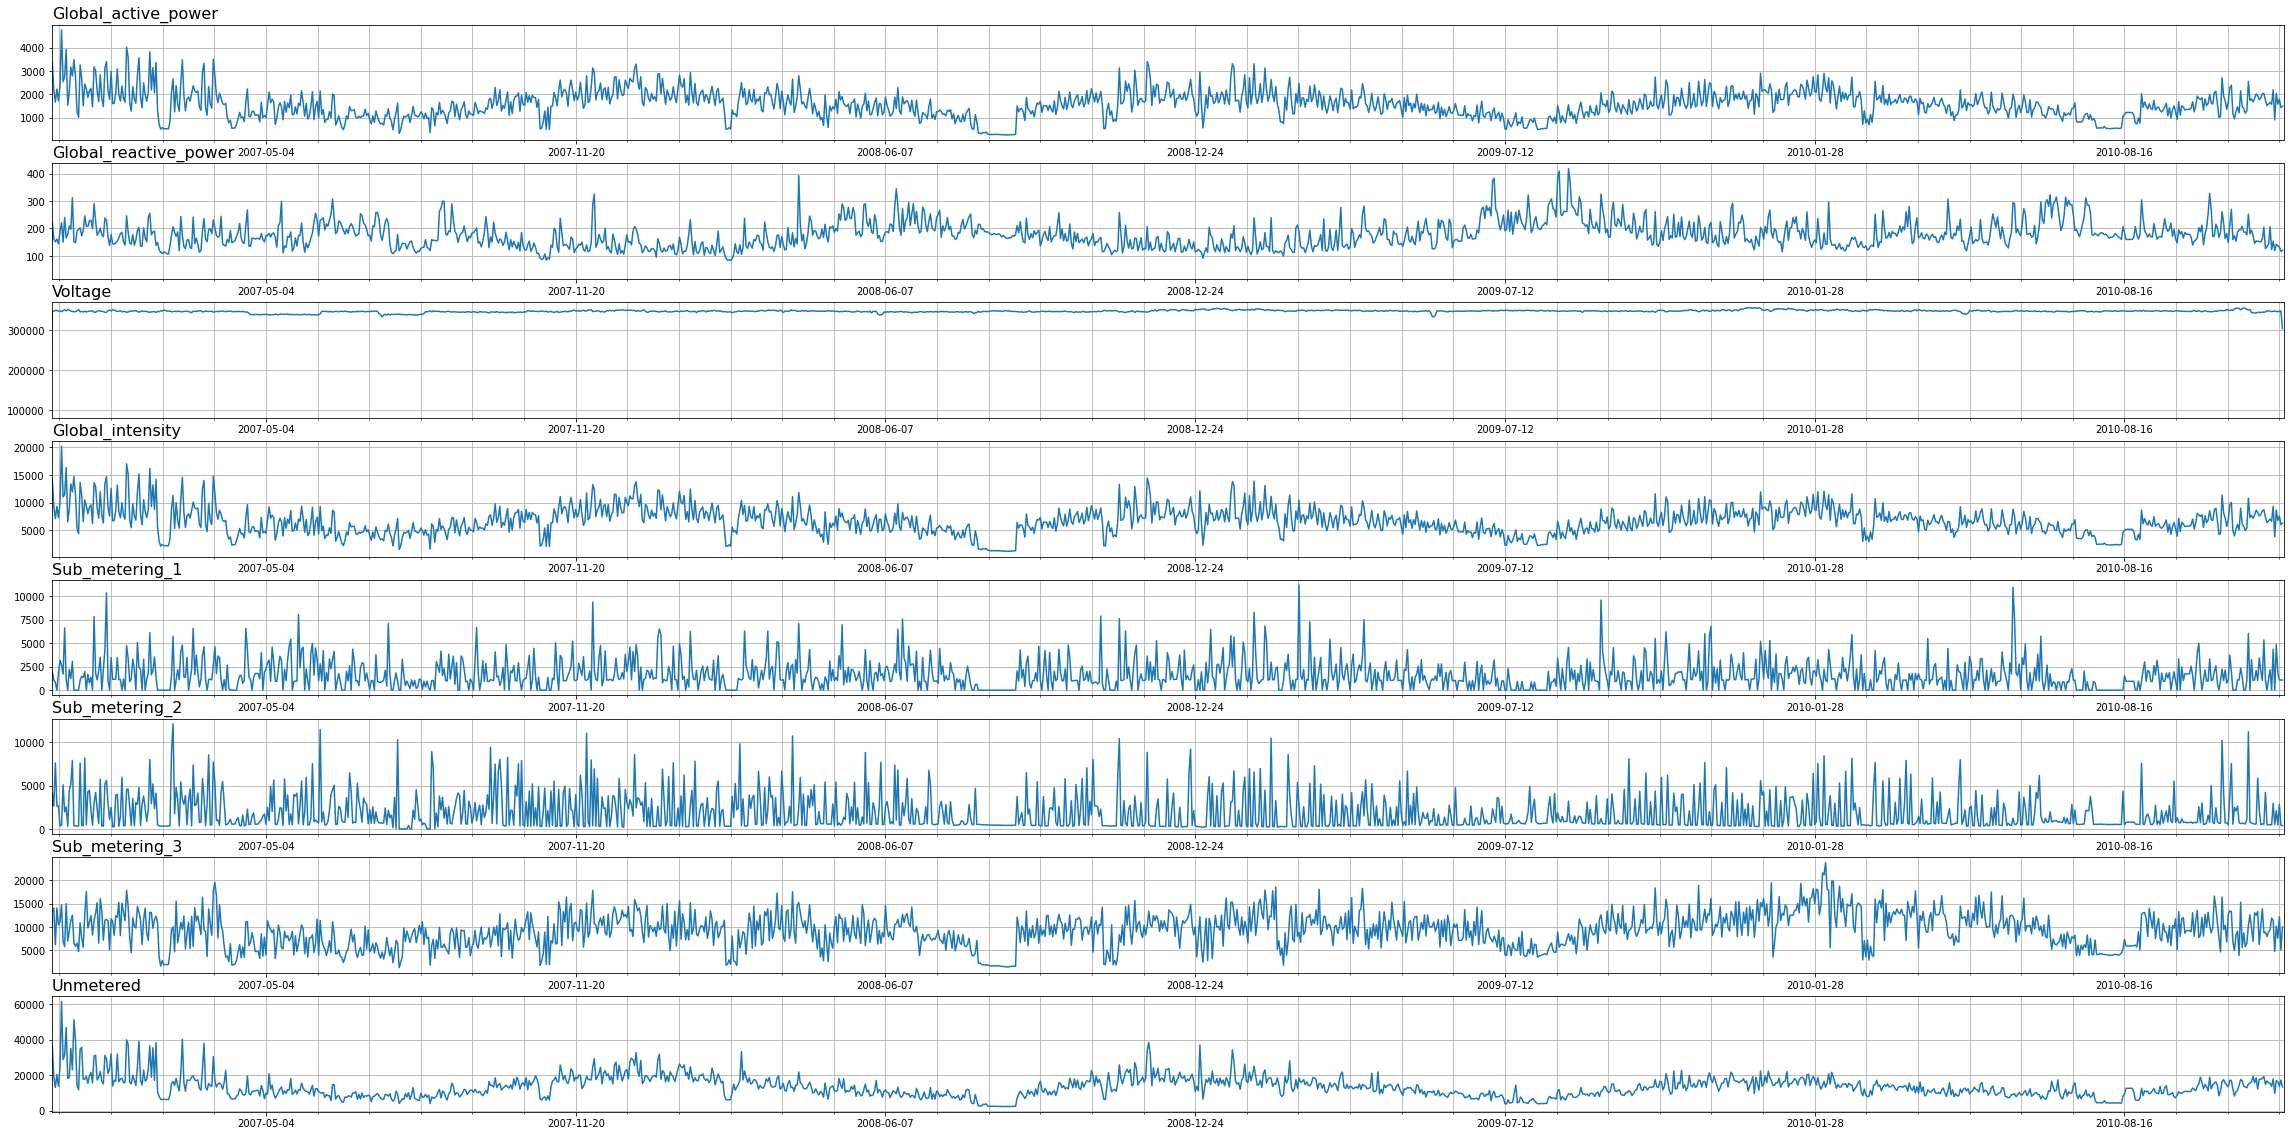

In [ ]:
# line plot for each variable (at the day level to avoid cluttered graphs)
fig, ax = plt.subplots(nrows = len(data.columns), ncols = 1, figsize=(40, 20))
ax = ax.ravel()
for i in range(len(data.columns)):
  name = data.columns[i]
  ax[i].plot(data[name].resample('D').sum())
  ax[i].set_xlim(data.index[0], data.index[-1])
  ax[i].set_title(name, loc="left", fontsize=16)
  ax[i].xaxis.set_major_locator(ticker.AutoLocator())
  ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(6))
  ax[i].grid(which='both')
plt.show()

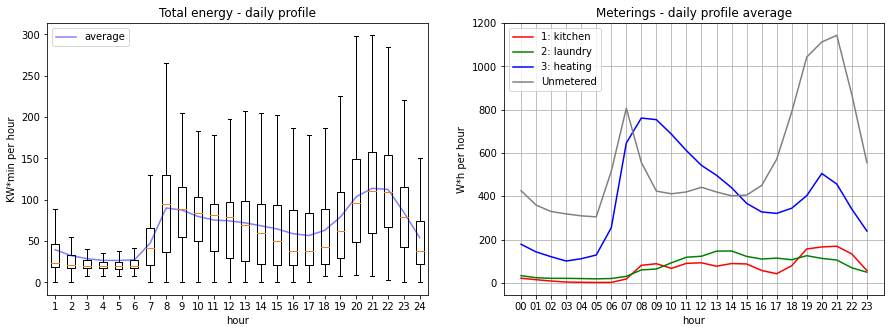

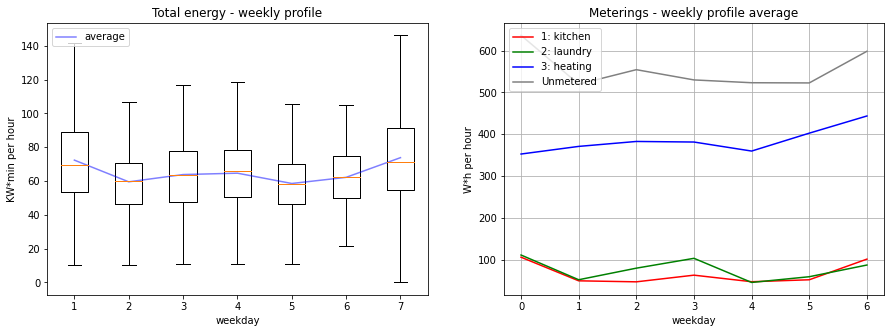

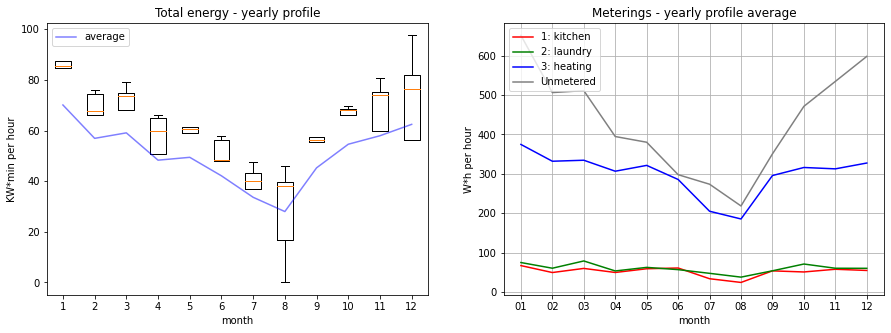

In [ ]:
def plot_global_and_meterings(total, metering_1, metering_2, metering_3, unmetered, texts):
  '''
  Plot a boxplot and average of the "Global_active_power" load profiles. Next to it, plot average load values for all meterings in the same chart.
  total: DataFrame of time series from "Global_active_power"
  metering_1, metering_2, metering_3, unmetered: Series containing mean values from each metering per time point
  texts: list with keywords for naming the label of the X-axis at [0] and the title of the plots [1]
  '''
  
  fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))
  ax[0].boxplot(total, showfliers=False)
  ax[0].plot(np.arange(1, total.shape[0] + 1), total.T.mean(skipna=True), label="average", color = 'b', alpha=0.5)
  ax[0].set_title('Total energy - %s profile' % (texts[0]))
  ax[0].set_xlabel('%s' % (texts[1]))
  ax[0].set_ylabel('KW*min per hour')
  ax[0].legend(loc='upper left')

  ax[1].plot(metering_1, label="1: kitchen", color = 'r')
  ax[1].plot(metering_2, label="2: laundry", color = 'g')
  ax[1].plot(metering_3, label="3: heating", color = 'b')
  ax[1].plot(unmetered, label="Unmetered", color = 'grey')
  ax[1].set_title('Meterings - %s profile average' % (texts[0]))
  ax[1].set_xlabel('%s' % (texts[1]))
  ax[1].set_ylabel('W*h per hour')
  ax[1].legend(loc='upper left')
  ax[1].grid()

# Let us see the load patterns globally and per meter at different scales: daily, weekly, yearly

# variables to adjust results to daily, weekly, and yearly profiles
scale_vars = [['H', '%H', 'hour', 'daily', 'D', 1], ['D', '%w', 'weekday', 'weekly', 'W', 24], ['M', '%m', 'month', 'yearly', 'y', 24*31]]

for vars in scale_vars:
  data_resampled = data.resample(vars[0]).sum()
  data_resampled[vars[2]] = data_resampled.index.strftime(vars[1])
  data_resampled.index = data_resampled.index.date

  data_resampled = data_resampled.pivot(columns=vars[2])
  data_resampled.index = pd.to_datetime(data_resampled.index)
  # Merge rows belonging to same period
  data_resampled = data_resampled.resample(vars[4]).sum() /vars[5] # normalize to consumption per hour
  
  total = data_resampled['Global_active_power'].T
  metering_1 = data_resampled['Sub_metering_1'].mean(skipna=True)
  metering_2 = data_resampled['Sub_metering_2'].mean(skipna=True)
  metering_3 = data_resampled['Sub_metering_3'].mean(skipna=True)
  unmetered = data_resampled['Unmetered'].mean(skipna=True)

  plot_global_and_meterings(total, metering_1, metering_2, metering_3, unmetered, [vars[3], vars[2]])

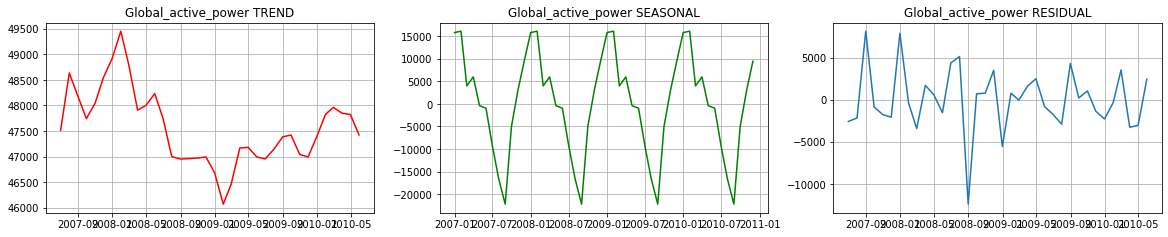

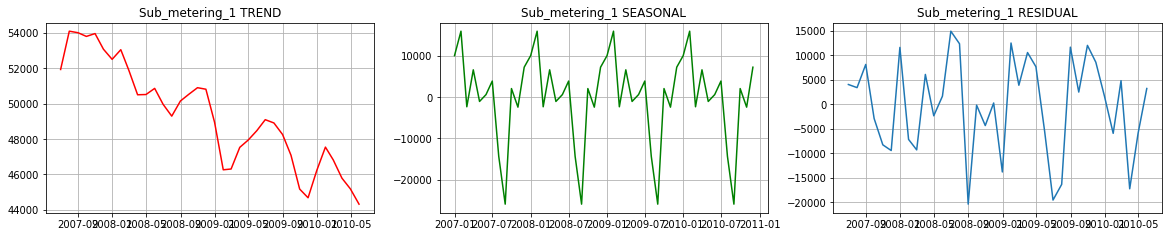

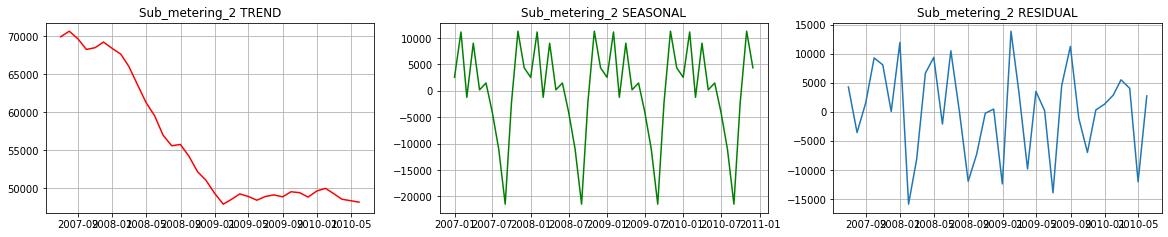

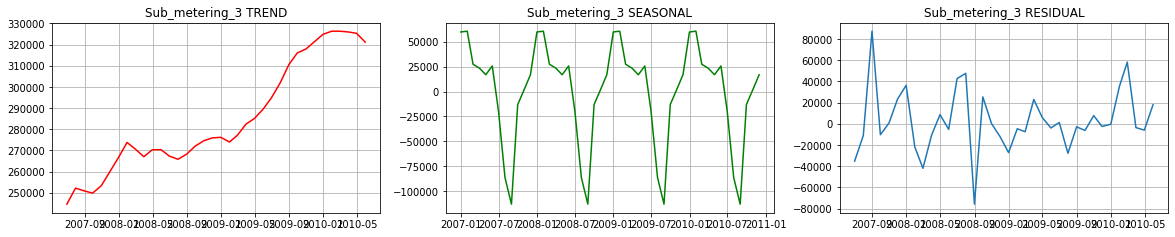

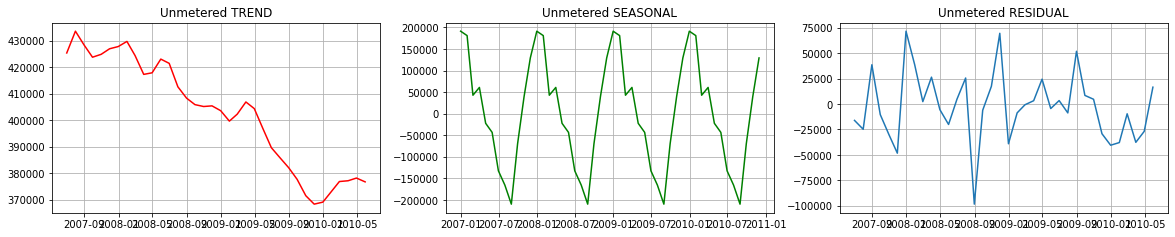

In [ ]:
# We can also visualize the trend through the 4 recorded years, which will also help visualize the seasonal components

variables = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','Unmetered']
for v in variables:
  fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 3.5))
  analysis = data[[v]].copy().resample('m').sum()

  # y(t) = Level + Trend + Seasonality + Noise
  decompose_result_mult = seasonal_decompose(analysis, model="additive")

  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid

  ax[0].set_title('%s TREND' % (v))
  ax[0].plot(decompose_result_mult.trend, color = 'r')
  ax[0].grid()

  ax[1].set_title('%s SEASONAL' % (v))
  ax[1].plot(decompose_result_mult.seasonal, color = 'g')
  ax[1].grid()

  ax[2].set_title('%s RESIDUAL' % (v))
  ax[2].plot(decompose_result_mult.resid)
  ax[2].grid()
  plt.show()

**SUMMARY:**
- "Global_active_power" and the submetering readings seem to be the most interesting attributes to understanding energy consumption patterns.
- Energy consumption dropped significantly in August 2008 for a few weeks. This could have resulted from a period where no one was at the house (e.g. a long trip).
- Energy load profiles have seasonality. We have plotted the daily, weekly and yearly variations as the most relevant.
  - In daily profiles there is the biggest variability as can be seen from the whisker plots.
  - "Metering 3" and "Unmetered" have the highest energy loads, especially at night.
  - At the weekly level, we see a more stable consumption throughout the week.
  - There is not many years on record, but there is a clear seasonality component that leads to increases in energy demand during colder months. However, with only 4 years of data, the conclusions taken from the yearly statistics must be taken with a pinch of salt due to the short history of data.
- The overall trend suggests a gradual reduction in energy consumption in all meters but number 3 (AC, water heater), which is in fact raising its load with the years. To understand this effect, we would need more information to investigate potential causes (change of behavior by dwellers, change in energy prices, issues/renewal of appliances...).

# Using a clustering method, identify different power usage patterns of the household.

In [ ]:
# LOAD DATASET
data = load_processed_dataset("household_power_consumption_processed.csv")

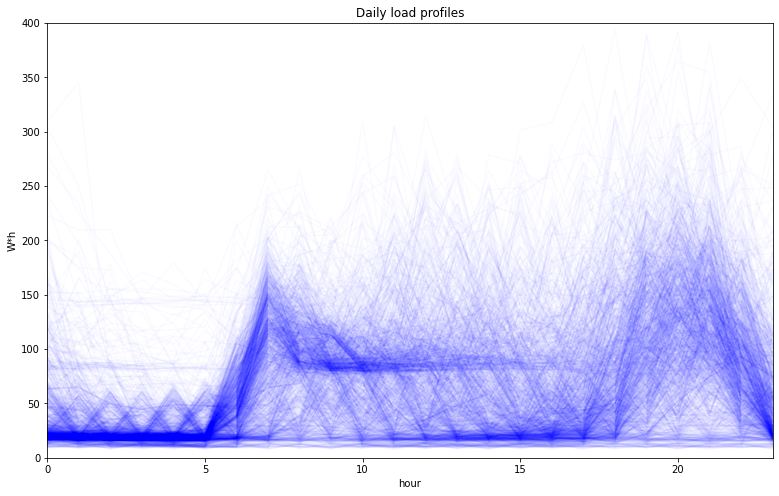

In [ ]:
# Let's try to find clusters in the daily consumption profiles. For that, let's turn each day into a separate time series

# Resample by hour
data_hourly = data.resample('H').sum()
data_hourly['hour'] = data_hourly.index.hour
data_hourly.index = data_hourly.index.date

data_hourly = data_hourly.pivot(columns='hour')
data_hourly = data_hourly.dropna() # only miss a few hours from the 1st and last day

plt.figure(figsize=(13,8))
plt.plot(data_hourly['Global_active_power'].T, color='blue', alpha=0.02)
plt.xlim(0,23)
plt.ylim(0,400)
plt.xlabel('hour')
plt.ylabel('W*h')
plt.title('Daily load profiles')
plt.show()

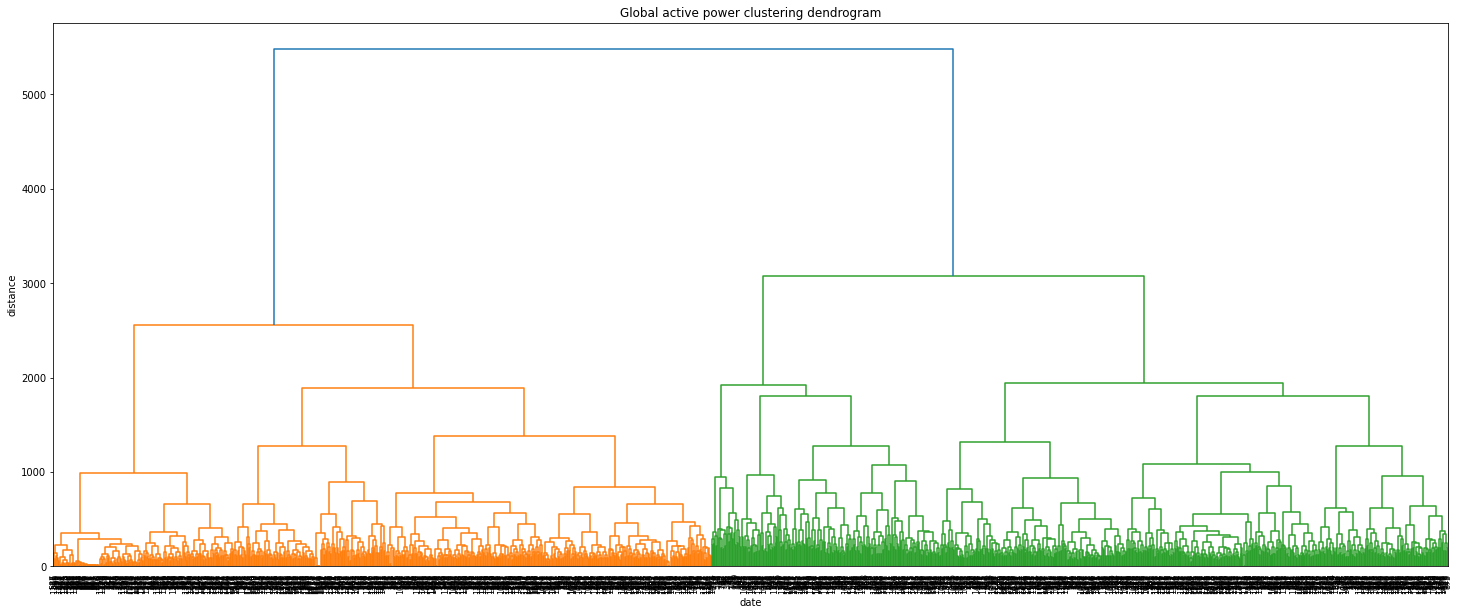

In [ ]:
# hierarchical clustering allows us to determine the number of clusters flexibly based on the distance between them
link_matrix = hac.linkage(data_hourly['Global_active_power'], method = 'ward', metric='euclidean') 

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Global active power clustering dendrogram')
plt.xlabel('date')
plt.ylabel('distance')
hac.dendrogram(
    link_matrix,
    leaf_rotation=90., 
    leaf_font_size=8., 
)
plt.show()

0 Cluster number 3 has 236 elements
1 Cluster number 4 has 525 elements
2 Cluster number 2 has 493 elements
3 Cluster number 1 has 186 elements


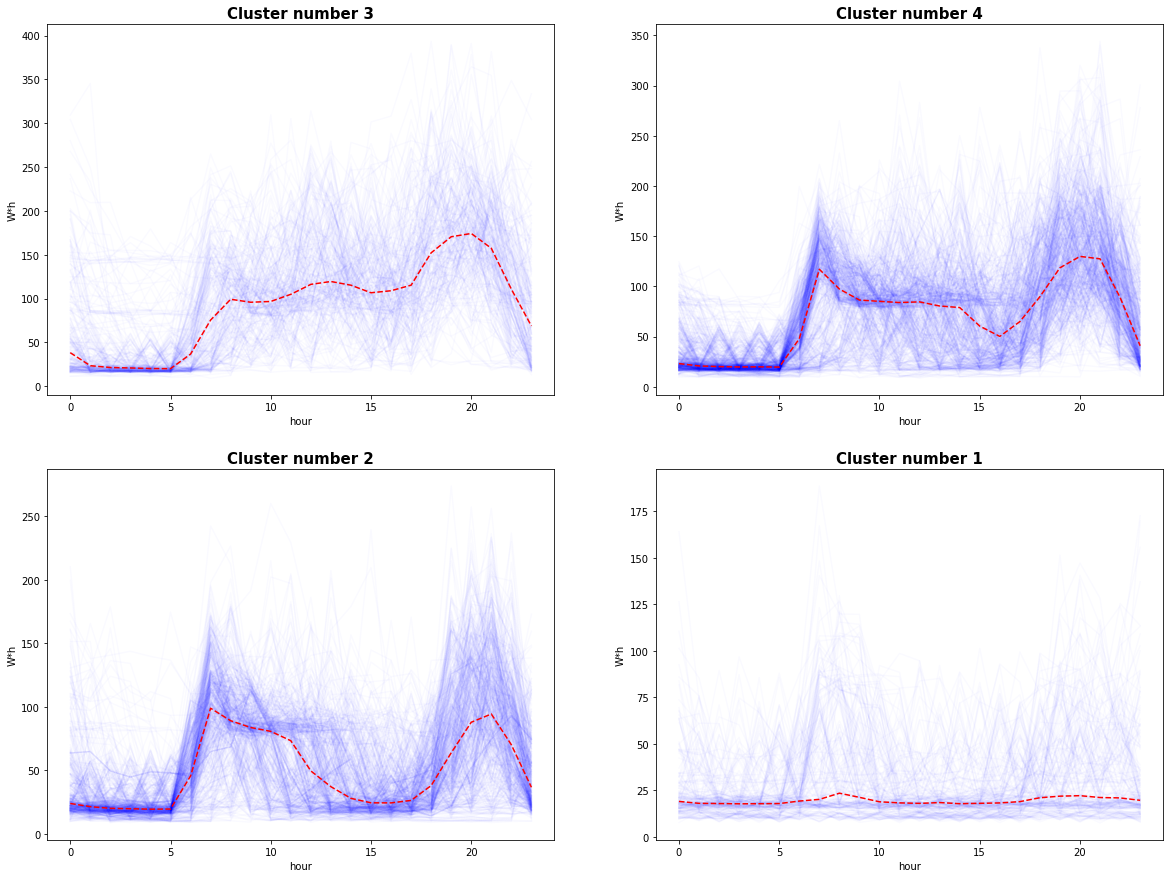

In [ ]:
def plot_results(time_series, link_matrix, cut_off_level, figX, figY):
  '''
  Print amount of datapoints belonging to each cluster. Display the time graph for the series belonging to each cluster with the median as red line.
  time_series: time series used as input for the hierarchical clustering
  D: linkage matrix
  cut_off_level: the number of clusters at which to cut the dendrogram
  figX, figY: size of figure plotted
  '''
  result = pd.Series(hac.fcluster(link_matrix, cut_off_level, criterion='maxclust'))
  clusters = result.unique()       
  fig = plt.subplots(figsize=(figX, figY))   
  mimg = math.ceil(cut_off_level/2.0)
  gs = gridspec.GridSpec(mimg,2, width_ratios=[1,1])   
  for ipic, c in enumerate(clusters):
      cluster_index = result[result==c].index
      print(ipic, "Cluster number %d has %d elements" % (c, len(cluster_index)))
      ax1 = plt.subplot(gs[ipic])
      ax1.plot(time_series.T.iloc[:,cluster_index], color='blue', alpha=0.02)
      ax1.plot(time_series.T.iloc[:,cluster_index].median(axis=1), color='red', ls='--')
      ax1.set_title(('Cluster number '+ str(c)), fontsize=15, fontweight='bold')
      ax1.set_xlabel('hour')   
      ax1.set_ylabel('W*h')      
  plt.show()

#---- evaluate the dendogram
cut_off_level = 4   # level where to cut off the dendogram
plot_results(data_hourly['Global_active_power'], link_matrix, cut_off_level, 20, 15)

Results for Sub_metering_1
0 Cluster number 3 has 445 elements
1 Cluster number 4 has 820 elements
2 Cluster number 2 has 159 elements
3 Cluster number 1 has 16 elements


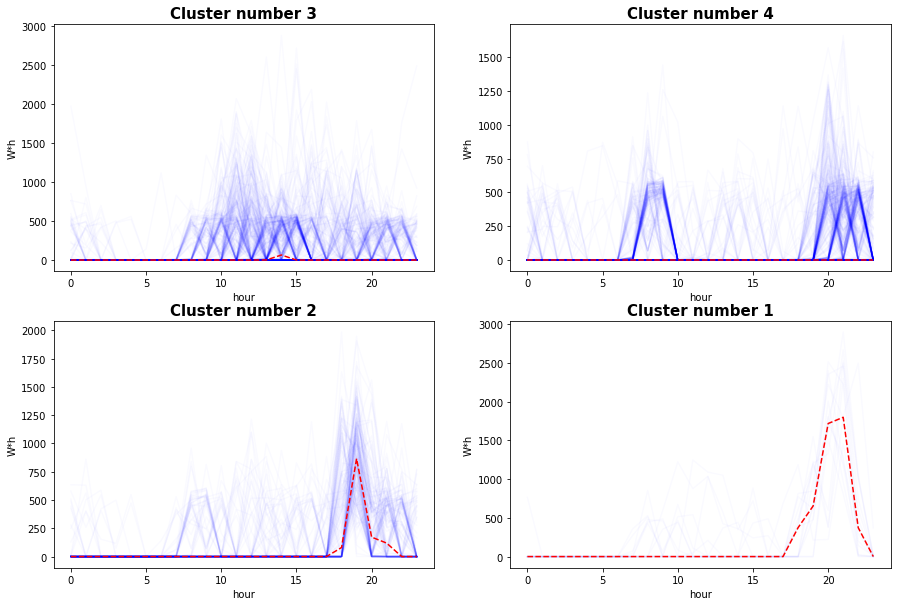

Results for Sub_metering_2
0 Cluster number 1 has 248 elements
1 Cluster number 2 has 962 elements
2 Cluster number 3 has 230 elements


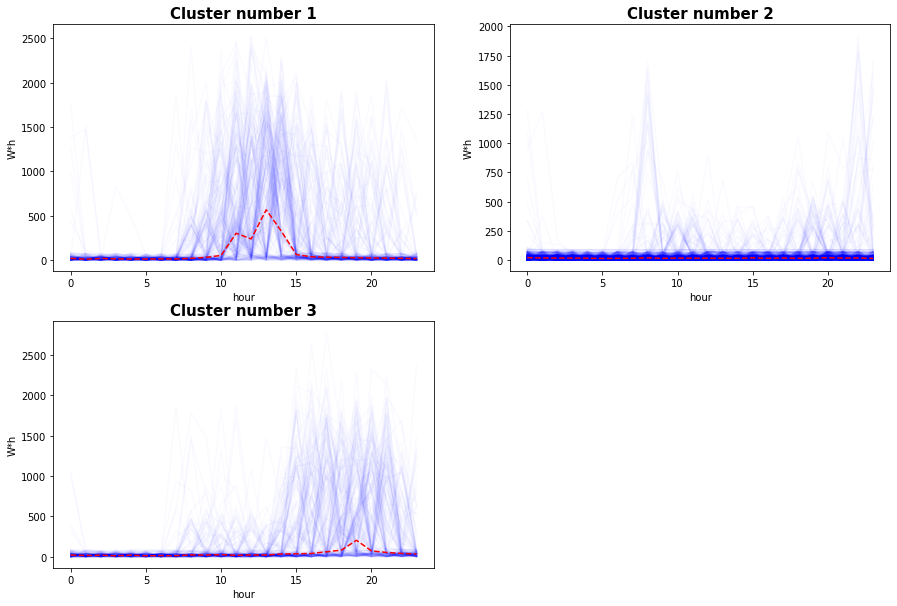

Results for Sub_metering_3
0 Cluster number 1 has 248 elements
1 Cluster number 2 has 962 elements
2 Cluster number 3 has 230 elements


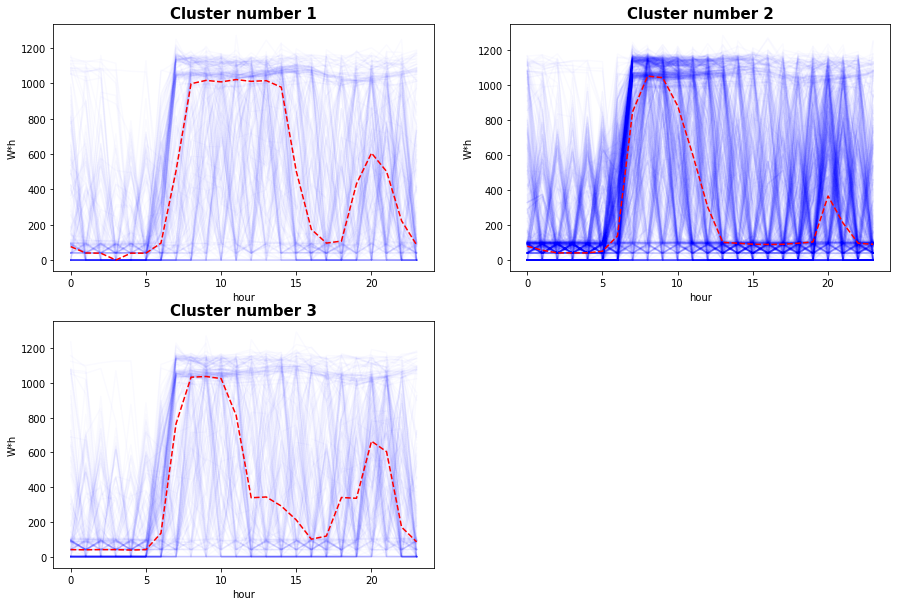

Results for Unmetered
0 Cluster number 2 has 45 elements
1 Cluster number 3 has 539 elements
2 Cluster number 1 has 856 elements


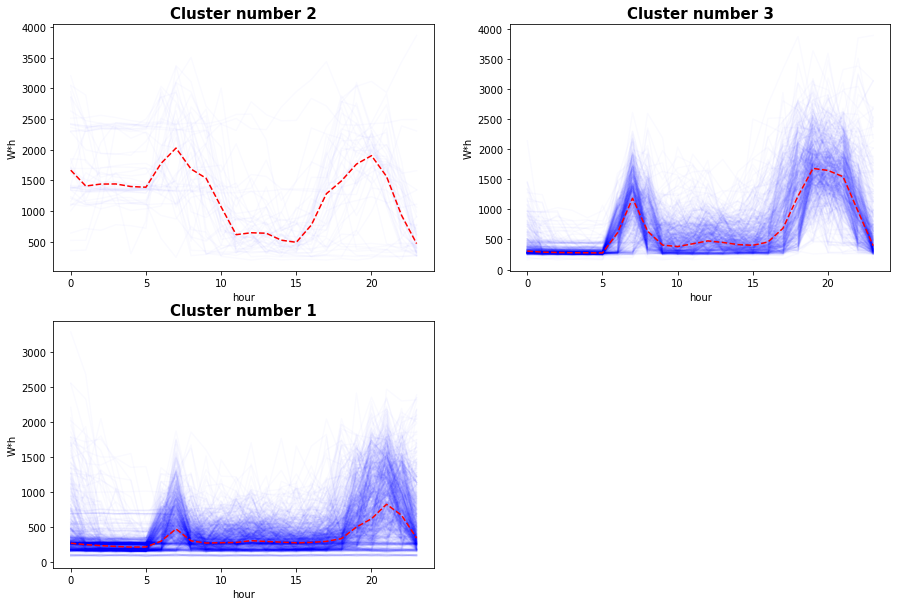

In [ ]:
# We can do the same for the meters
def cluster_and_plot(time_series, time_series_name, time_series_col_plot, cut_off_level):
  '''
  Get link matrix from clustering time_series and display clustered series for each cluster.
  time_series: time series used as input for the hierarchical clustering
  time_series_name: time series name for printing
  time_series_col_plot: column of the dataset to be used for plotting the load profiles of each cluster
  cut_off_level: the number of clusters at which to cut the dendrogram
  '''
  link_matrix = hac.linkage(time_series, method = 'ward', metric='euclidean')
  print('Results for', time_series_name) 
  plot_results(data_hourly[time_series_col_plot], link_matrix, cut_off_level, 15, 10)
  return link_matrix

_ = cluster_and_plot(data_hourly['Sub_metering_1'], 'Sub_metering_1', 'Sub_metering_1', 4)
_ = cluster_and_plot(data_hourly['Sub_metering_2'], 'Sub_metering_2','Sub_metering_2', 3)
_ = cluster_and_plot(data_hourly['Sub_metering_2'], 'Sub_metering_3','Sub_metering_3', 3)
_ = cluster_and_plot(data_hourly['Unmetered'], 'Unmetered','Unmetered', 3)

Alternatively, if we are looking for specific patterns arising from different submetering profile combinations, we can apply clustering using several dimensions.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Results for 2D t-SNE
0 Cluster number 1 has 230 elements
1 Cluster number 4 has 561 elements
2 Cluster number 3 has 316 elements
3 Cluster number 2 has 333 elements


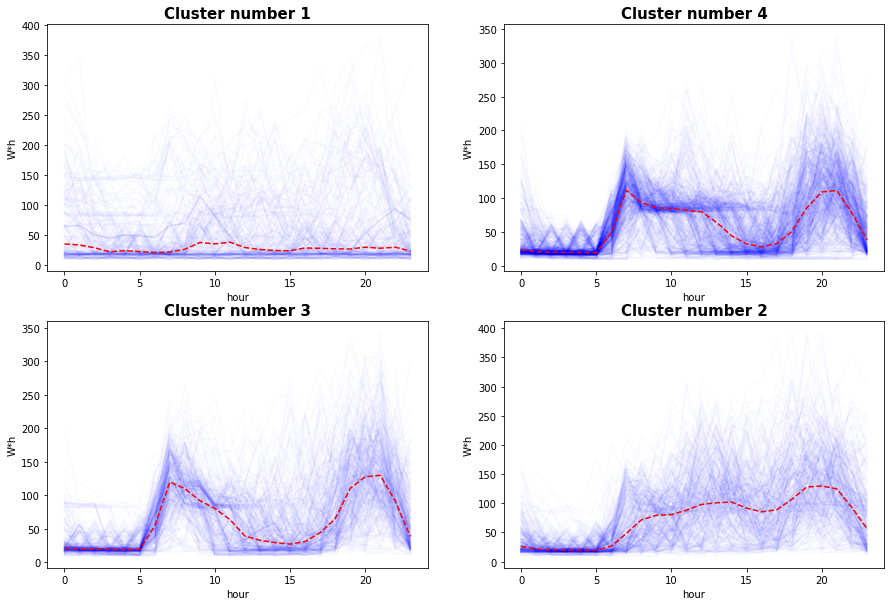

In [ ]:
# I will apply dimensionality reduction (PCA + tSNE) and then cluster on the 2D result for an alternative clustering method
sc = StandardScaler()
# standardizing the data
data_hourly_std = sc.fit_transform(data_hourly[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Unmetered']].values) 

pca = PCA(n_components = 50) # Reduce the number of dimensions in a series from 96 (24h x 4meters) to 50
data_hourly_pca = pca.fit_transform(data_hourly_std)

tsne = TSNE(n_components=2, random_state=0, perplexity = 30) # Further reduce the dimensions from 50 to 2 per day series
data_hourly_tsne = tsne.fit_transform(data_hourly_pca)

_ = cluster_and_plot(data_hourly_tsne, "2D t-SNE", "Global_active_power", 4)

**SUMMARY:**
- We have clustered the daily load profiles in 2 ways using a hierarchical Ward linkage method.
  - First we have time the raw time series as an input for the algorithm, and identified clusters for each meter profile and global energy consumption separately.
  - Secondly, we have applied PCA + t-SNE dimensionality reduction to condense the information of the submeters of each daily series into 2D.
- For both methods, the profiles of the clusters look similar, which tells us that the 2D version still contains the information of the whole "Global_active_power" series.
- As for the cluster shapes, we can deduce some behavior from them. For instance, in which days there is no one at home, or days when they go out during a part of the day. From the individual meter clusters, we can be even more precise and know which days they do laundry or cook dinner.
- Ideally, we can define the number of clusters based on the distance we want to have between them to identify them as separate. In the absence of a clear motivation or direction for the clustering, I have chosend to simply have the complete dendrogram as initial step and then choose the amount of clusters to display manually.
- As a subsequent step to understand energy consumption, we could investigate what do days in the same cluster have in common beyond the energy load (e.g. by looking at whether the days in a specific cluster belong to the same weekday, month or season).

# Using a time series regression method, predict the next month’s consumption patterns.

In [ ]:
# LOAD DATASET
data = load_processed_dataset("household_power_consumption_processed.csv")

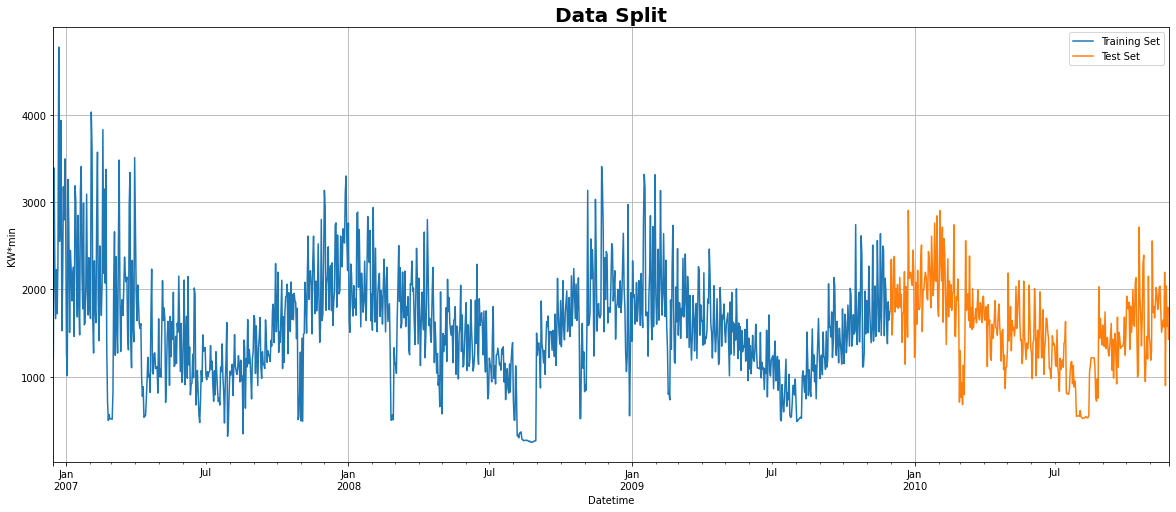

In [ ]:
# We will use aggregated values
data_daily = data.resample('D').sum()

# Let's keep the last 25 % of the data as test set (around 1 full year)
train, test = train_test_split(data_daily, test_size=0.25, shuffle=False)

# Plot the data split
plt.figure(figsize=(20,8))

train['Global_active_power'].plot(label='Training Set')
test['Global_active_power'].plot(label='Test Set')
plt.title('Data Split', weight='bold', fontsize=20)
plt.ylabel('KW*min')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Since the idea is to use XGBoost, we must first check for stationarity of the time series with Augmented Dickey-Fuller test
def ADF_cal(x):
  '''
  Calculate stationarity of time series data using the Augmented Dickey-Fuller test.
  x: time series data
  '''
  result = adfuller(x)
  ADF_stat = result[0]
  p = result[1]
  print("ADF Statistic: %f" % ADF_stat)
  print("p-value: %f" % p)
  print("Critical Values")
  levels = [.01, .05, .1]
  i = 0
  for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))
    hyp = p < levels[i]
    if ADF_stat < value:
      cert = (1-levels[i])*100
      print("{}% certain this is stationary".format(cert))
      print('Reject H0: {}'.format(hyp))
      break
    i = i+1
    if i >= 3:
      print("Less than 90% certain that data is stationary")
      print('Reject H0: {}'.format(hyp))

ADF_cal(data_daily['Global_active_power'])

ADF Statistic: -3.697385
p-value: 0.004150
Critical Values
	1%: -3.435
99.0% certain this is stationary
Reject H0: True


The ADF test confirmed the stationarity of the time series, so we can move on without needing to transform the data.

Naive prediction:
> RMSE on test data = 532.3228
> MAPE on test data = 27.9829%


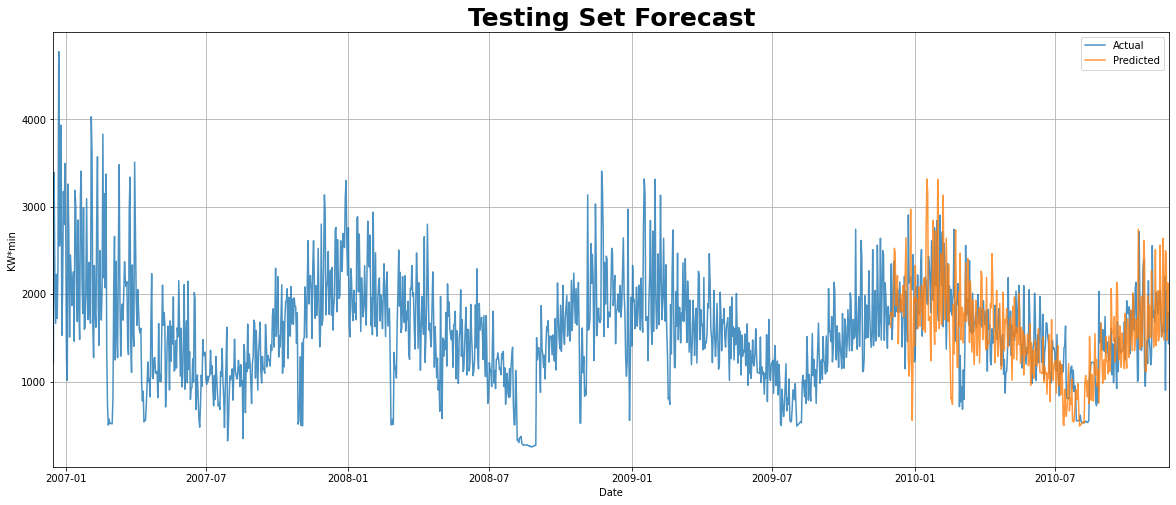

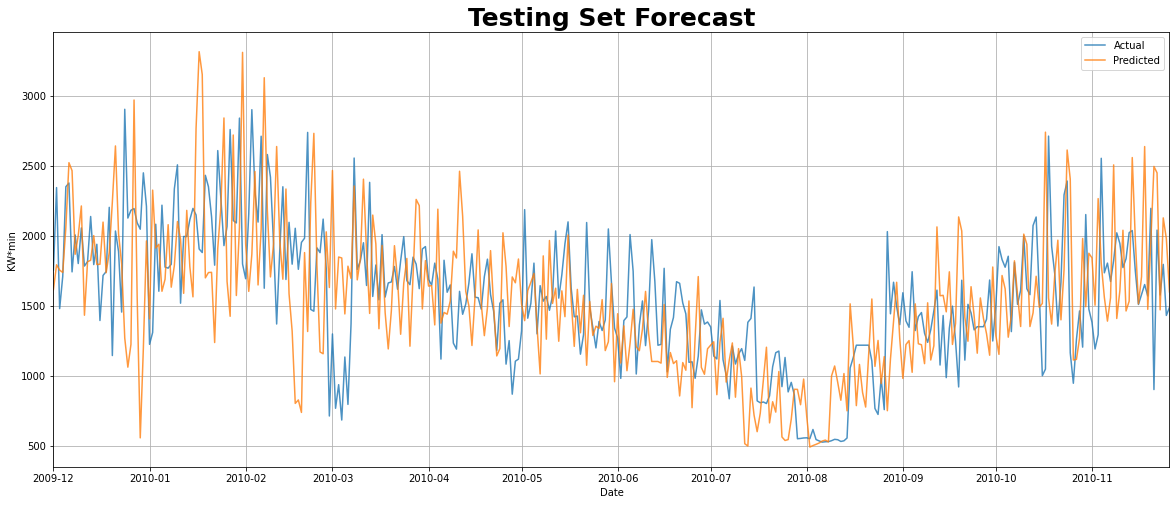

In [ ]:
# Let us first make a naive predictive model as baseline

# Let's simply say that a certain value will repeat itself every year
def naive_predict(data, X_test):
  '''
  Return a prediction that equals the value of the previous year
  data: available historical data
  X_test: times to be predicted
  '''
  pred_test =  data['Global_active_power'].loc[X_test.index - pd.DateOffset(years=1)]
  pred_test.index = X_test.index
  return pred_test

def mean_absolute_percentage_error(y_true, y_pred): 
  '''
  Calculates MAPE
  y_true: actual values
  y_pred: predicted values
  '''
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_error(y_true, y_pred, data):
  '''
  Yields 2 plots: 1 showing the whole dataset with the predictions; and other showing the actual and predicted values only over the test dates
  y_true: actual target values
  y_pred: predicted values
  data: complete dataset
  '''
  df_plot = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

  plt.figure(figsize=(20,8))
  plt.plot(data, label='Actual', alpha = 0.8)
  plt.plot(df_plot['y_pred'], label='Predicted', alpha = 0.8)
  plt.title('Testing Set Forecast', weight='bold', fontsize=25)
  plt.xlabel('Date')
  plt.ylabel('KW*min')
  plt.legend()
  plt.grid()
  plt.xlim(data.index.date[0], data.index.date[-1])
  plt.show()

  # Plot test predictions over targets
  plt.figure(figsize=(20,8))
  plt.plot(df_plot['y_true'], label='Actual', alpha = 0.8)
  plt.plot(df_plot['y_pred'], label='Predicted', alpha = 0.8)
  plt.title('Testing Set Forecast', weight='bold', fontsize=25)
  plt.xlabel('Date')
  plt.ylabel('KW*min')
  plt.legend()
  plt.grid()
  plt.xlim(df_plot['y_true'].index.date[0], df_plot['y_true'].index.date[-1])
  plt.show()


# Predict
pred_test_naive = naive_predict(data_daily, test)
# RMSE & MAPE Computation
rmse_test_naive = np.sqrt(mean_squared_error(test['Global_active_power'], pred_test_naive))
mape_test_naive = mean_absolute_percentage_error(test['Global_active_power'], pred_test_naive)
print('Naive prediction:\n> RMSE on test data = {:.4f}\n> MAPE on test data = {:.4f}%'.format(
    rmse_test_naive,
    mape_test_naive
))
# Plot whole series with predictions
plot_error(test['Global_active_power'], pred_test_naive, data_daily['Global_active_power'])

Now, we can build our model. We start by creating some features to be fed to XGBoost.

In [ ]:
# Create features to be used for model training
def create_features(df, historical_length, label=None):
    """
    Creates time series features from datetime index and features from lagged values
    df: dataset in DataFrame type
    historical_length: number of lagged periods used as features
    label: target variable
    """
    df['date'] = df.index
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day

    # Transform into trigonometric variables to account for cyclical nature of time attributes
    df['day_of_week_sin'] = np.sin(df.day_of_week*(2.*np.pi/7))
    df['day_of_week_cos'] = np.cos(df.day_of_week*(2.*np.pi/7))
    df['day_of_year_sin'] = np.sin((df.day_of_year-1)*(2.*np.pi/365))
    df['day_of_year_cos'] = np.cos((df.day_of_year-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
    df['quarter_sin'] = np.sin((df.quarter-1)*(2.*np.pi/4))
    df['quarter_cos'] = np.cos((df.quarter-1)*(2.*np.pi/4))

    # Create df with time features
    X = df[['day_of_week_sin', 'day_of_week_cos', 'day_of_month', 'day_of_year_sin', 'day_of_year_cos',
      'quarter_sin', 'quarter_cos','month_sin', 'month_cos']]

    # Autoregressive features: add energy consumption of the previous periods
    for i in range(historical_length, 0, -1):
      s = df['Global_active_power'].shift(i)
      col_name = str(i) + '_periods_ago'
      s.rename(col_name, inplace=True)
      X = X.join(s)
    
    if label:
        y = df[label]
        return X, y
    return X

lagging_values = 7
X_train, y_train = create_features(train, lagging_values, label='Global_active_power')
X_test, y_test = create_features(test, lagging_values, label='Global_active_power')
display(X_train.head())
display(y_train.head())

day_of_week_sin  day_of_week_cos  day_of_month  day_of_year_sin  \
Datetime                                                                      
2006-12-16        -0.974928        -0.222521            16        -0.271958   
2006-12-17        -0.781831         0.623490            17        -0.255353   
2006-12-18         0.000000         1.000000            18        -0.238673   
2006-12-19         0.781831         0.623490            19        -0.221922   
2006-12-20         0.974928        -0.222521            20        -0.205104   

            day_of_year_cos  quarter_sin   quarter_cos  month_sin  month_cos  \
Datetime                                                                       
2006-12-16         0.962309         -1.0 -1.836970e-16       -0.5   0.866025   
2006-12-17         0.966848         -1.0 -1.836970e-16       -0.5   0.866025   
2006-12-18         0.971100         -1.0 -1.836970e-16       -0.5   0.866025   
2006-12-19         0.975065         -1.0 -1.836970e-16       -0.5   0.866025   
2006-12-20         0.978740         -1.0 -1.836970e-16       -0.5   0.866025   

            7_periods_ago  6_periods_ago  5_periods_ago  4_periods_ago  \
Datetime                                                                 
2006-12-16            NaN            NaN            NaN            NaN   
2006-12-17            NaN            NaN            NaN            NaN   
2006-12-18            NaN            NaN            NaN            NaN   
2006-12-19            NaN            NaN            NaN            NaN   
2006-12-20            NaN            NaN            NaN       1209.176   

            3_periods_ago  2_periods_ago  1_periods_ago  
Datetime                                                 
2006-12-16            NaN            NaN            NaN  
2006-12-17            NaN            NaN       1209.176  
2006-12-18            NaN       1209.176       3390.460  
2006-12-19       1209.176       3390.460       2203.826  
2006-12-20       3390.460       2203.826       1666.194

Datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [ ]:
# XGBoost training
# Walk-forward cross-validation
tscv = TimeSeriesSplit(math.floor(train.shape[0]/(31)), test_size = (31))
# Hyperparameter grid search
gamma = [0, 0.5, 1]
n_estimators = [300, 500, 1000]
learning_rate = [0.01, 0.1, 0.2]

# Perform grid search
score = {}
for tr_index, val_index in tscv.split(X_train):
  X_tr, X_val = X_train.iloc[tr_index], X_train.iloc[val_index]
  y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
  for g in gamma:
    for ne in n_estimators:
      for lr in learning_rate:
        xgb = XGBRegressor(objective='reg:squarederror',
            gamma=g,
            n_estimators=ne,
            learning_rate=lr,
        )
        xgb.fit(X_tr, y_tr, early_stopping_rounds=10,
                eval_set=[[X_tr, y_tr], [X_val, y_val]],
                eval_metric='rmse',
                verbose = True
                )
        score[xgb.evals_result_['validation_1']['rmse'][-1]] = {
            'params': {'gamma': g, 'n_estimators': ne, 'learning_rate': lr},
            'train_error_history': xgb.evals_result_['validation_0']['rmse'],
            'val_error_history': xgb.evals_result_['validation_1']['rmse']
        }

# Keep model with lowest RMSE on validation set
best_model_history = score[min(score.keys())]
print(best_model_history['params'])

Se han truncado las últimas 5000 líneas del flujo de salida.
[84]	validation_0-rmse:814.286	validation_1-rmse:788.444
[85]	validation_0-rmse:808.214	validation_1-rmse:783.315
[86]	validation_0-rmse:802.217	validation_1-rmse:778.247
[87]	validation_0-rmse:796.323	validation_1-rmse:772.317
[88]	validation_0-rmse:790.472	validation_1-rmse:765.727
[89]	validation_0-rmse:784.684	validation_1-rmse:759.993
[90]	validation_0-rmse:778.998	validation_1-rmse:754.03
[91]	validation_0-rmse:773.358	validation_1-rmse:747.669
[92]	validation_0-rmse:767.78	validation_1-rmse:742.345
[93]	validation_0-rmse:762.237	validation_1-rmse:736.498
[94]	validation_0-rmse:756.788	validation_1-rmse:729.435
[95]	validation_0-rmse:751.409	validation_1-rmse:724.092
[96]	validation_0-rmse:746.096	validation_1-rmse:718.776
[97]	validation_0-rmse:740.856	validation_1-rmse:712.847
[98]	validation_0-rmse:735.675	validation_1-rmse:707.888
[99]	validation_0-rmse:730.526	validation_1-rmse:702.451
[100]	validation_0-rmse:725.4

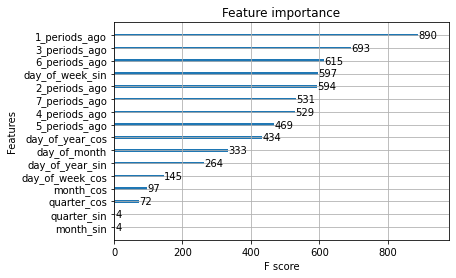

In [ ]:
# plot feature importance
xgb_best_model = XGBRegressor(objective='reg:squarederror')
xgb_best_model.set_params(**best_model_history['params'])
xgb_best_model.fit(X_train, y_train)
plot_importance(xgb_best_model)
plt.show()

From the feature importance plot, we notice that lagging values were more useful than time features during training. This information could be used to refine the variables used for training (e.g. removing those who did not contribute).

XGBoosting with GridSearch:
> RMSE on training data = 300.4651
> RMSE on test data = 338.9332
> MAPE on train data = 17.4404%
> MAPE on test data = 17.1081%


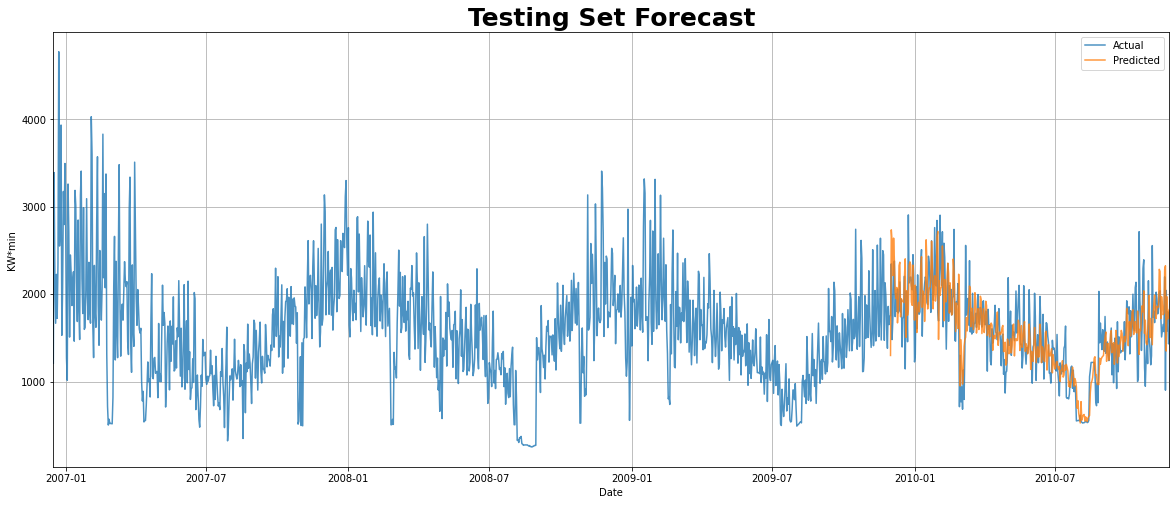

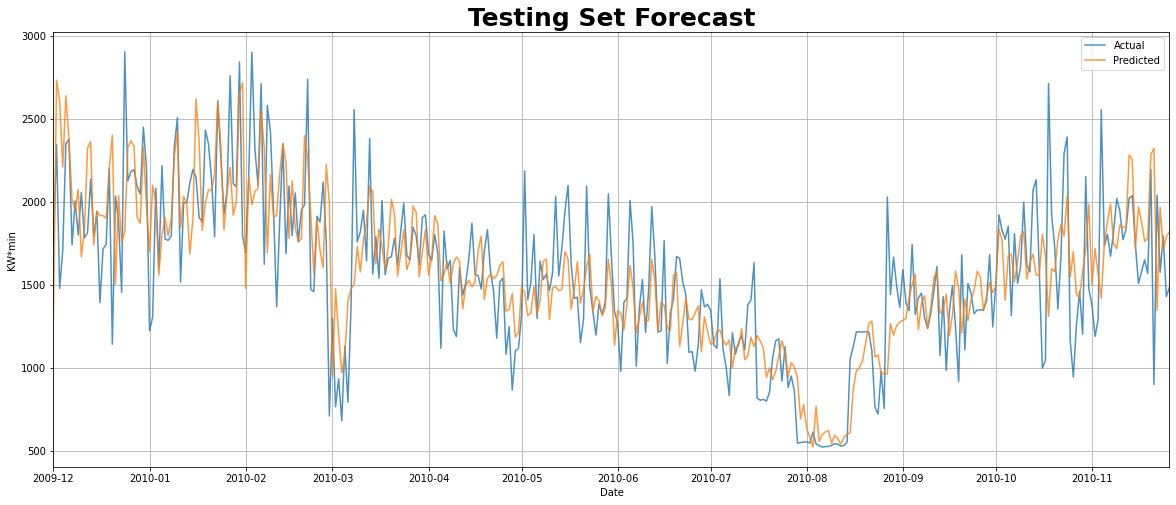

In [ ]:
# Use trained model to predict on test set
pred_train = xgb_best_model.predict(X_train)
pred_test = xgb_best_model.predict(X_test)

# RMSE & MAPE Computation
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mape_train = mean_absolute_percentage_error(y_train, pred_train)
mape_test = mean_absolute_percentage_error(y_test, pred_test)

print('XGBoosting with GridSearch:\n> RMSE on training data = {:.4f}\n> RMSE on test data = {:.4f}\n> MAPE on train data = {:.4f}%\n> MAPE on test data = {:.4f}%'.format(
    rmse_train,
    rmse_test,
    mape_train,
    mape_test
))

# Plot whole series with predictions
plot_error(test['Global_active_power'], pred_test, data_daily['Global_active_power'])

The model achieved a significant improvement over the baseline. 
We can now retrain it on all the data available and forecast next month's consumption.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


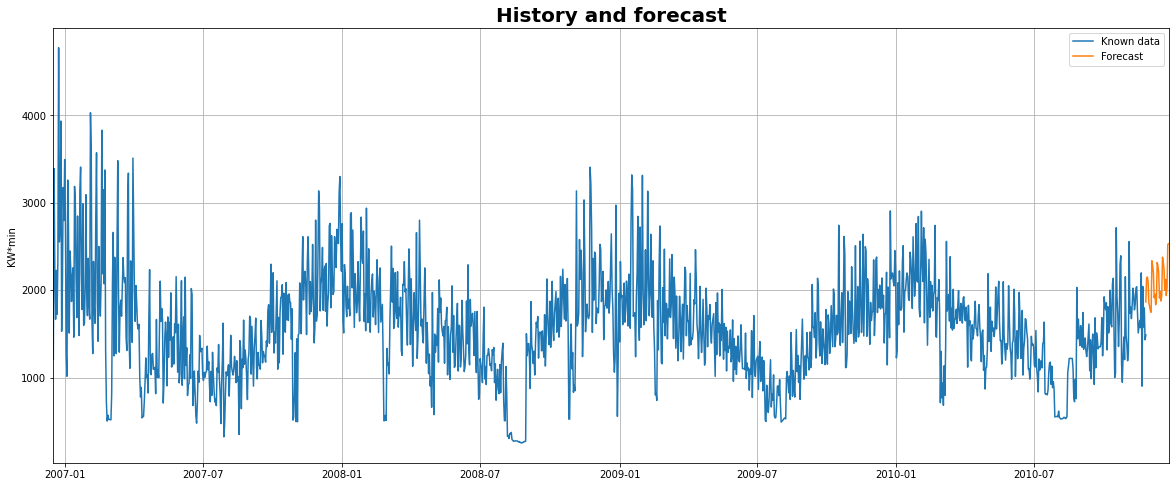

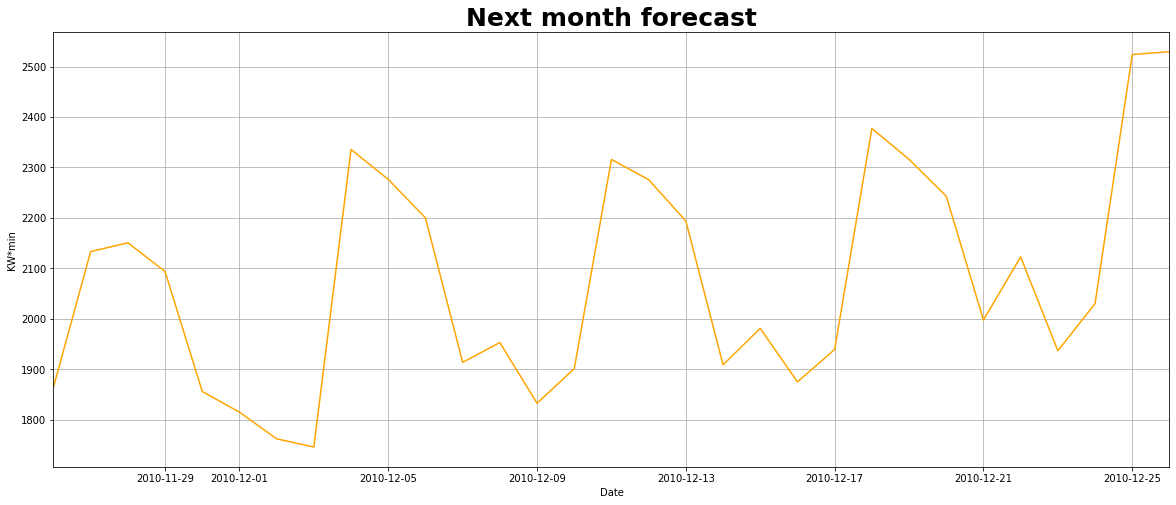

In [ ]:
# Create future month to predict values
periods_to_predict = 31
# Create dataframe with dates
future = pd.DataFrame({'Datetime': pd.date_range(start=data_daily.index.date[-1], periods = periods_to_predict, freq='d')})
future['Global_active_power'] = np.nan
future = future.set_index('Datetime');
# Transform features including lagging values from available data
X_future, _ = create_features(pd.concat([data_daily, future]), lagging_values, label='Global_active_power')
X_future = X_future.tail(periods_to_predict)


# Retrain model on full dataset
xgb_full_dataset_model = xgb_best_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
# Save final model
dump(xgb_full_dataset_model, 'xgb_energy.joblib')

# Predict future month values in a multi-step fashion 
pred_future = [np.nan] * periods_to_predict
for next in range(periods_to_predict):
  pred_future[next] = xgb_full_dataset_model.predict(X_future.iloc[0+next , :], validate_features=False)
  for lag in range(lagging_values): # Fill predicted value as lag predictor for following periods
    col = str(lag+1) + '_periods_ago'
    if (next+lag+1) < 31:
      X_future[col].iloc[next + lag + 1] = pred_future[next]



# Plot prediction as continuation of known data
plt.figure(figsize=(20,8))
plt.plot(data_daily['Global_active_power'], label='Known data')
plt.plot(pd.date_range(start=data_daily.index.date[-1], periods = periods_to_predict, freq='d'), pred_future, label='Forecast')
plt.title('History and forecast', weight='bold', fontsize=20)
plt.ylabel('KW*min')
plt.xlim(data_daily.index.min(), data_daily.index.max() + pd.DateOffset(days = periods_to_predict))
plt.legend()
plt.grid()
plt.show()

# Plot forecast only
plt.figure(figsize=(20,8))
plt.plot(pd.date_range(start=data_daily.index.date[-1], periods= periods_to_predict, freq='d'), pred_future, color='orange', label='Predicted')
plt.title('Next month forecast', weight='bold', fontsize=25)
plt.xlabel('Date')
plt.ylabel('KW*min')
plt.grid()
plt.xlim(X_future.index.date[0], X_future.index.date[-1])
plt.plot(pred_future)
plt.show()

**SUMMARY:**
- We have verified the stationarity of our time series, requied to use XGBoost.
- A naive model was used to set a baseline performance. It had a 28% MAP error on the test set.
- We used lagging values from previous periods together with cyclical versions of the date parameters as training features.
- A walk-forward validation on **XGBoost** was used to create the regressive model to select the training parameters.
- **The model achieved** a 17% error on the test set. **An error 11% lower than the baseline.**
- To predict the following month consumption pattern, a multi-step prediction was performed.

As potential follow-on experiments:
- Some further feature engineering may improve the result. For instance:
  - Creating features from the differences in values between periods
  - Creating features from rolling statistics
  - Using open weather data or forecast to enrich the dataset
- It would be worth comparing the results with those obtained from a different algorithm, like a multilayered perceptron or LSTM.


# Using publicly available data, estimate the GHG Scope 2 emissions of the household on a monthly basis.

Taking public data on energy mix produced in France in "2012" from https://www.rte-france.com/en/eco2mix/download-indicators.

In [ ]:
# Column names translated to English: oil, coal, gas, nuclear, eolic, solar, hydraulic, bioenergy
col_list = ["Date", "Fioul", "Charbon", "Gaz", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]
FR_energy_2012 = pd.read_csv("eCO2mix_RTE_Annuel-Definitif_2012.xls - eCO2mix_RTE_Annuel-Definitif_2012.xls.csv", \
                             header=0, sep = ',', \
                             usecols=col_list,
                             infer_datetime_format=True, parse_dates = {'Datetime': ['Date']}
)
FR_energy_2012.dropna(axis = 0, how ='any', inplace = True)
FR_energy_2012 = FR_energy_2012.set_index('Datetime')
print(FR_energy_2012.info())
display(FR_energy_2012.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 2012-01-01 to 2012-12-31
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fioul        17568 non-null  float64
 1   Charbon      17568 non-null  float64
 2   Gaz          17568 non-null  float64
 3   Nucléaire    17568 non-null  float64
 4   Eolien       17568 non-null  float64
 5   Solaire      17568 non-null  float64
 6   Hydraulique  17568 non-null  float64
 7   Bioénergies  17568 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB
None


Fioul  Charbon     Gaz  Nucléaire  Eolien  Solaire  Hydraulique  \
Datetime                                                                      
2012-01-01  492.0     25.0  3816.0    52697.0  3588.0      0.0       7922.0   
2012-01-01  492.0     25.0  3816.0    52697.0  3588.0      0.0       7922.0   
2012-01-01  492.0     25.0  3834.0    51747.0  3536.0      0.0       7598.0   
2012-01-01  491.0     25.0  3832.0    51950.0  3526.0      0.0       7299.0   
2012-01-01  492.0     25.0  3839.0    51625.0  3535.0      0.0       7159.0   

            Bioénergies  
Datetime                 
2012-01-01        719.0  
2012-01-01        719.0  
2012-01-01        721.0  
2012-01-01        722.0  
2012-01-01        719.0

In [ ]:
# Let us calculate the mix for each energy source per month
FR_energy_2012 = FR_energy_2012.resample('M').sum()
display(FR_energy_2012)


Fioul    Charbon        Gaz   Nucléaire     Eolien    Solaire  \
Datetime                                                                        
2012-01-31   893223.0  1537770.0  8150964.0  85553029.0  3170579.0   233044.0   
2012-02-29  2070743.0  5111869.0  9966798.0  77305538.0  2242160.0   404651.0   
2012-03-31   875593.0  2921514.0  6575791.0  75117981.0  1950245.0   665576.0   
2012-04-30   705657.0  3298460.0  2813866.0  66152813.0  3137120.0   614459.0   
2012-05-31   526000.0  1706754.0  1234807.0  58064275.0  1944665.0   851728.0   
2012-06-30   487928.0  1921841.0  1883312.0  53071389.0  1984293.0   892308.0   
2012-07-31   486885.0  2219951.0  1523626.0  57578155.0  1820288.0  1009949.0   
2012-08-31   425732.0  2321209.0  2083998.0  56578430.0  1811217.0   993730.0   
2012-09-30   488235.0  2752125.0  1495278.0  60210051.0  1858631.0   767666.0   
2012-10-31   615352.0  4048925.0  2190865.0  65550051.0  2698039.0   526133.0   
2012-11-30   760870.0  3619202.0  5852959.0  74165545.0  2616325.0   335482.0   
2012-12-31   752155.0  3431985.0  6307254.0  79761460.0  4571866.0   270895.0   

            Hydraulique  Bioénergies  
Datetime                              
2012-01-31   13372457.0    1039213.0  
2012-02-29   10405047.0     924169.0  
2012-03-31    7740614.0    1080601.0  
2012-04-30   10521234.0     820778.0  
2012-05-31   15256472.0     943855.0  
2012-06-30   13594535.0     876263.0  
2012-07-31    9787619.0    1032382.0  
2012-08-31    7098815.0     986193.0  
2012-09-30    7278993.0     956554.0  
2012-10-31    9030896.0     916143.0  
2012-11-30    9738172.0    1046085.0  
2012-12-31   12898119.0    1050680.0

In [ ]:
# Transformation into %
col_list.remove("Date")
FR_energy_monthly_split = pd.DataFrame(columns=col_list)
for index, row in FR_energy_2012.iterrows():
  total = row.sum()
  FR_energy_monthly_split.loc[index] = row.mul(1/total)

display(FR_energy_monthly_split)

Fioul   Charbon       Gaz  Nucléaire    Eolien   Solaire  \
2012-01-31  0.007839  0.013495  0.071531   0.750793  0.027824  0.002045   
2012-02-29  0.019097  0.047144  0.091918   0.712947  0.020678  0.003732   
2012-03-31  0.009033  0.030141  0.067842   0.774988  0.020121  0.006867   
2012-04-30  0.008013  0.037455  0.031952   0.751187  0.035623  0.006977   
2012-05-31  0.006532  0.021194  0.015334   0.721040  0.024149  0.010577   
2012-06-30  0.006531  0.025723  0.025208   0.710347  0.026559  0.011943   
2012-07-31  0.006452  0.029419  0.020191   0.763040  0.024123  0.013384   
2012-08-31  0.005888  0.032106  0.028825   0.782558  0.025052  0.013745   
2012-09-30  0.006440  0.036304  0.019725   0.794249  0.024518  0.010127   
2012-10-31  0.007191  0.047314  0.025601   0.765983  0.031528  0.006148   
2012-11-30  0.007753  0.036880  0.059642   0.755753  0.026661  0.003419   
2012-12-31  0.006898  0.031473  0.057841   0.731458  0.041927  0.002484   

            Hydraulique  Bioénergies  
2012-01-31     0.117353     0.009120  
2012-02-29     0.095960     0.008523  
2012-03-31     0.079859     0.011149  
2012-04-30     0.119472     0.009320  
2012-05-31     0.189454     0.011721  
2012-06-30     0.181960     0.011729  
2012-07-31     0.129708     0.013681  
2012-08-31     0.098186     0.013640  
2012-09-30     0.096019     0.012618  
2012-10-31     0.105530     0.010706  
2012-11-30     0.099233     0.010660  
2012-12-31     0.118283     0.009635

In [ ]:
# LOAD DATASET
data = load_processed_dataset("household_power_consumption_processed.csv")

The average yearly consumption is 9.42 MWh


Global_active_power  tCO2_emitted  tCO2_per_MWh
Datetime                                                   
2006-12-31             0.697113      0.045986      0.065966
2007-01-31             1.150248      0.062791      0.054589
2007-02-28             0.941563      0.098832      0.104966
2007-03-31             0.981075      0.069999      0.071350
2007-04-30             0.629668      0.038705      0.061469

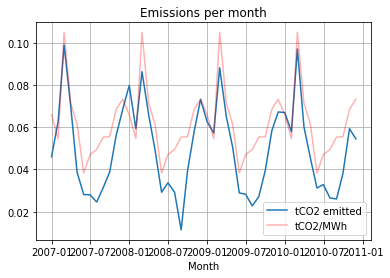

In [ ]:
# Turn kw*min to MW*h
data_monthly = pd.DataFrame(data['Global_active_power'].resample('M').sum())
data_monthly = data_monthly.mul(1/(60*1000))
print('The average yearly consumption is %.2f MWh' % (data_monthly.sum()/4)) # 9.42 MWh is a reasonable number

# From https://www.rte-france.com/en/eco2mix/co2-emissions, values in t CO2eq / MWh (current estimates, may differ from 2012 or previous years):
oil_ghg = 0.777
coal_ghg = 0.986
gas_ghg = 0.429
biofuel_ghg = 0.494
# Other sources are assumed to have 0 CO2 emissions

# Add a column to our monthly DataFrame with the calculated emissions
for idx, row in FR_energy_monthly_split.iterrows():
  data_monthly.loc[data_monthly.index.month == idx.month, "tCO2_emitted"] = \
  data_monthly.loc[data_monthly.index.month == idx.month, "Global_active_power"] * \
  (oil_ghg * row["Fioul"] + coal_ghg * row["Charbon"] + gas_ghg * row["Gaz"] + biofuel_ghg * row["Bioénergies"])

# Column to show CO2 emitted per MWh depending on the month
data_monthly["tCO2_per_MWh"] = data_monthly["tCO2_emitted"] / data_monthly["Global_active_power"]
display(data_monthly.head())

plt.figure(figsize=(15,10))
plt.title("Emissions per month")
plt.plot(data_monthly["tCO2_emitted"], label="tCO2 emitted")
plt.plot(data_monthly["tCO2_per_MWh"], label="tCO2/MWh", color = 'r', alpha = 0.3)
plt.xlabel('Month')
plt.grid()
plt.legend(loc="lower right")
plt.show()

**SUMMARY:**
- Using official data from 2012 from https://www.rte-france.com, a reference for the energy mix used in each month was obtained, together with estimated emissions depending on the energy source.
- The average yearly emissions in the years on record are estimated to be 9.42 MWh/year.
- As expected, the emissions go up in the months were energy demand increases.
- The energy production emits more CO2 per MWh when energy demand goes up.
- Seasonality in energy sources:
  - Energy from gas goes up during Winter.
  - Hydraulic energy goes up during Spring.
  - Solar energy goes up during Summer.

# Assuming a hypothetical grid where generated power is mostly renewables during the day, and fossil fuels at night, identify potential changes to the household’s patterns to minimize its GHG emissions

Based on the daily charts from Section 2, we can see that **the major contributors to energy consumption are metering 3 (water heater and AC) and the unmetered energy.** 

Knowing that heating is a major contributor to energy consumption in a household and observing that the unmetered energy load is similar to metering 3 across graphs, **it is likely that most of the unmetered consumption is due to other kinds of heating** (e.g. radiators).

Based on this, **one recommendation would be avoiding showers at night, and minimizing the use of artificial heating**. For instance, open the windows to get breeze in Summer instead of turning the AC on; and close the window and wear warm clothing at home in Winter.

Even though the other metering are less relevant, **the daily load of metering 1 (oven, microwave, dishwasher) rises at night. Avoiding using the oven for dinner or running the dishwasher the next day in the morning** instead of at night would further minimize the nightly demand.

Lastly, as for metering 2 (washing machine, drier, refligerator, light), **doing laundry during the day could further reduce emissions.**